In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

Acknowledgements
Relevant Papers:

Ahmed M., Kashem M.A., Rahman M., Khatun S. (2020) Review and Analysis of Risk Factor of Maternal Health in Remote Area Using the Internet of Things (IoT). In: Kasruddin Nasir A. et al. (eds) InECCE2019. Lecture Notes in Electrical Engineering, vol 632. Springer, Singapore. [Web Link]

IoT based Risk Level Prediction Model for Maternal Health Care in the Context of Bangladesh, STI-2020, [under publication in IEEE]

1. Data Pre-processing

In [3]:
df = pd.read_csv("Maternal Health Risk Data Set.csv")

In [4]:
print(df.head(10))

   Age  SystolicBP  DiastolicBP     BS  BodyTemp  HeartRate  RiskLevel
0   25         130           80  15.00      98.0         86  high risk
1   35         140           90  13.00      98.0         70  high risk
2   29          90           70   8.00     100.0         80  high risk
3   30         140           85   7.00      98.0         70  high risk
4   35         120           60   6.10      98.0         76   low risk
5   23         140           80   7.01      98.0         70  high risk
6   23         130           70   7.01      98.0         78   mid risk
7   35          85           60  11.00     102.0         86  high risk
8   32         120           90   6.90      98.0         70   mid risk
9   42         130           80  18.00      98.0         70  high risk


In [5]:
risk_mapping = {'low risk': 0, 'mid risk': 1, 'high risk': 2}
df["RiskLevel"] = df["RiskLevel"].map(risk_mapping)
print(df.head(10))

   Age  SystolicBP  DiastolicBP     BS  BodyTemp  HeartRate  RiskLevel
0   25         130           80  15.00      98.0         86          2
1   35         140           90  13.00      98.0         70          2
2   29          90           70   8.00     100.0         80          2
3   30         140           85   7.00      98.0         70          2
4   35         120           60   6.10      98.0         76          0
5   23         140           80   7.01      98.0         70          2
6   23         130           70   7.01      98.0         78          1
7   35          85           60  11.00     102.0         86          2
8   32         120           90   6.90      98.0         70          1
9   42         130           80  18.00      98.0         70          2


In [6]:
X = df.drop(columns=["RiskLevel"])
y = df["RiskLevel"]

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
print("Training set:", X_train.shape, y_train.shape)
print("Test set:", X_test.shape, y_test.shape)

Training set: (811, 6) (811,)
Test set: (203, 6) (203,)


2. Check Class Distribution

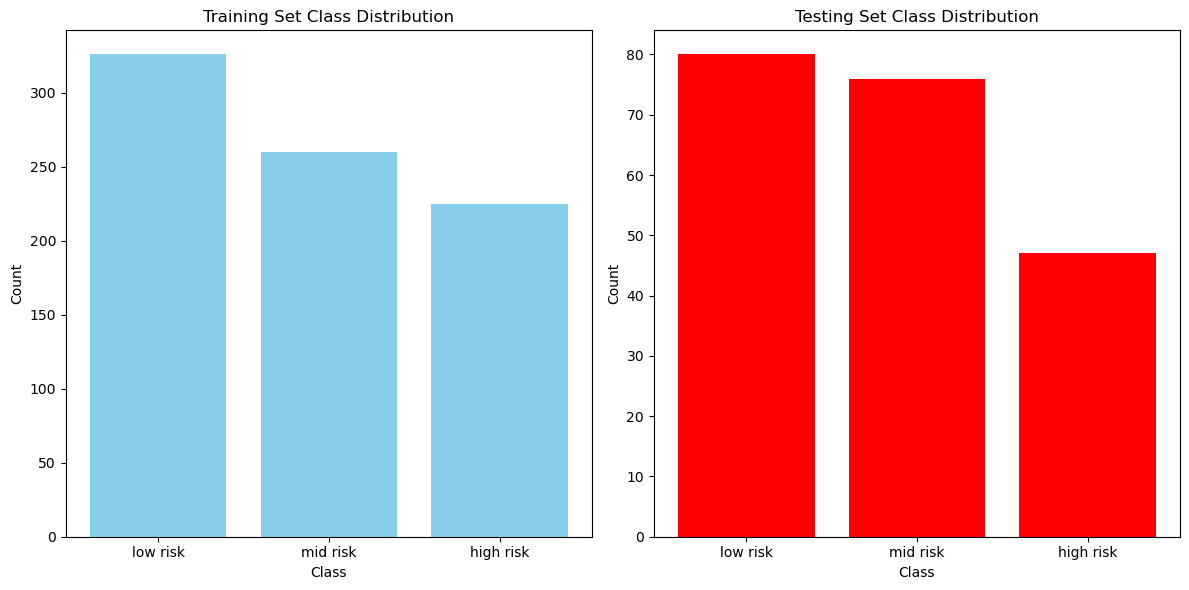

In [9]:
# Count the occurrences of each class in the training and validation datasets
train_class_counts = np.bincount(y_train)
test_class_counts = np.bincount(y_test)

# Class name definitions
classes = ['low risk', 'mid risk', 'high risk']

# Plot the distribution of classes
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Training set class distribution
ax[0].bar(classes, train_class_counts, color='skyblue')
ax[0].set_title('Training Set Class Distribution')
ax[0].set_xlabel('Class')
ax[0].set_ylabel('Count')

# Testing set class distribution
ax[1].bar(classes, test_class_counts, color='red')
ax[1].set_title('Testing Set Class Distribution')
ax[1].set_xlabel('Class')
ax[1].set_ylabel('Count')

plt.tight_layout()
plt.show()

3. Initial Model

In [10]:
model = XGBClassifier(eval_metric="mlogloss")
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, objective='multi:softprob', ...)

In [11]:
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")
print("Classification Report:\n", classification_report(y_test, y_pred, target_names=classes))

Accuracy: 0.8424
Classification Report:
               precision    recall  f1-score   support

    low risk       0.87      0.82      0.85        80
    mid risk       0.81      0.84      0.83        76
   high risk       0.85      0.87      0.86        47

    accuracy                           0.84       203
   macro avg       0.84      0.85      0.85       203
weighted avg       0.84      0.84      0.84       203



4. Hyperparameter Tuning

In [13]:
param_grid = {
    'n_estimators': [100, 300, 200, 500],  
    'max_depth': [3, 5, 7, 9],  
    'learning_rate': [0.01, 0.05, 0.1, 0.2],  
    'subsample': [0.6, 0.7, 0.8, 1.0],  
    'colsample_bytree': [0.6, 0.7, 0.8, 1.0]
}

In [14]:
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

model = XGBClassifier(eval_metric="mlogloss")
grid_search = GridSearchCV(model, param_grid, scoring='accuracy', cv=stratified_kfold, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 1024 candidates, totalling 5120 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='mlogloss', feature_types=None,
                                     gamma=None, grow_policy=None,
                                     importan...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.6, 0.7, 0.8, 1.0],
                         'learning_rate': [0.01, 0.05, 0.1, 0.2],
                         'max_depth': [3, 5, 7, 9],
                         'n_estimators': [100, 300, 200, 500],
                         'subsample': [0.6, 0.7, 0.8, 1.0]},
             scoring='accuracy', verbose=2)

In [15]:
print("Best Estimator:", grid_search.best_estimator_)
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
print(f"Optimized Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("Classification Report:\n", classification_report(y_test, y_pred, target_names=classes))

Best Estimator: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=7,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=300,
              n_jobs=None, num_parallel_tree=None, objective='multi:softprob', ...)
Optimized Accuracy: 0.8473
Classification Report:
               precision    recall  f1-score   support

    low risk       0.86      0.84      0.85        80
    mid risk       0.82      0.84      0.83        76
   

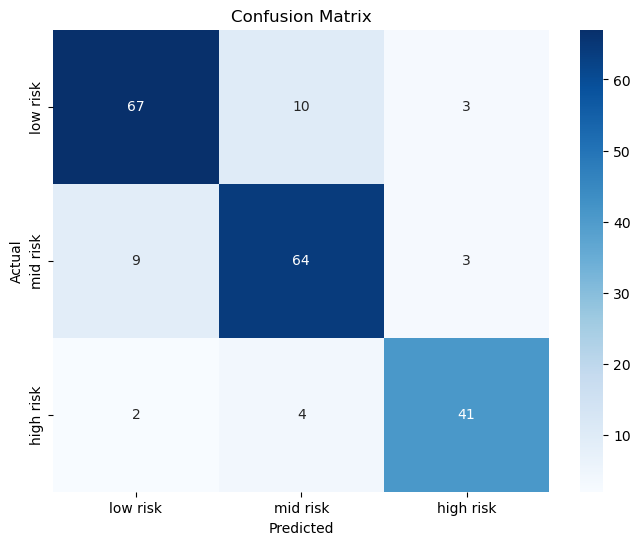

In [42]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

5. Analysis of Features

In [16]:
feature_importance = best_model.feature_importances_
importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importance})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

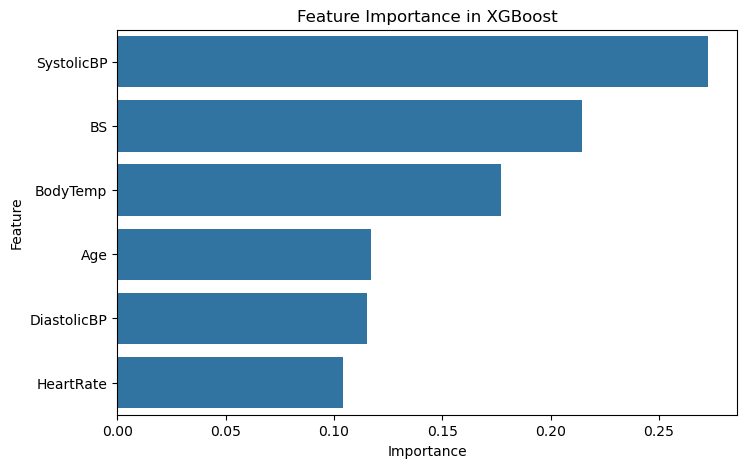

In [17]:
plt.figure(figsize=(8, 5))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title("Feature Importance in XGBoost")
plt.show()

In [36]:
best_model.save_model("maternal_risk_xgb.json")